In [1]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
from dataloader import MyDataset, ToTensor
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from cnnNet import Net
import torch

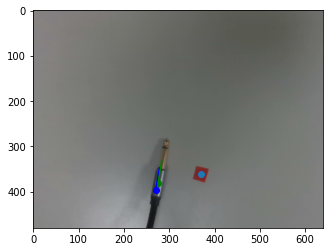

275.386376953125 380.8185791015625 0.1633661409459194


In [2]:
train_dataset = MyDataset(csv_file='data/train_labels.csv',
                                root_dir='data/',
                                transform=transforms.Compose([
                                    ToTensor()
                                ]))

validation_dataset = MyDataset(csv_file='data/validation_labels.csv',
                                root_dir='data/',
                                transform=transforms.Compose([
                                    ToTensor()
                                ]))

train_dataloader = DataLoader(train_dataset, batch_size=4,
                        shuffle=True, num_workers=0)

validation_dataloader = DataLoader(validation_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

model = Net()
model.load_state_dict(torch.load('model/best.pth'))
model.eval()
for i, data in enumerate(validation_dataloader, 0):
    inputs, labels = data['image'], data['labels']
    predict = model(inputs)[0]
    predict = predict.detach().numpy()
    labels = labels.numpy()[0]
    inputs = inputs.numpy()[0]

    # show image
    plt.imshow(inputs.transpose(1, 2, 0).astype(np.uint8))
    # show ground truth location and prediction
    plt.scatter(predict[0] * 6.4, predict[1] * 4.8, c = 'blue')
    plt.scatter(labels[0] * 6.4, labels[1] * 4.8, c = 'green')

    # show rotation
    x = predict[0] * 6.4
    y = predict[1] * 4.8
    theta = predict[2] / 180 * np.pi
    length = 50
    rotation_prediction = plt.plot([x, x + length * np.sin(theta)], [y, y - length * np.cos(theta)], c = 'blue')

    x = labels[0] * 6.4
    y = labels[1] * 4.8
    theta = labels[2] / 180 * np.pi
    length = 50
    rotation_ground_truth = plt.plot([x, x + length * np.sin(theta)], [y, y - length * np.cos(theta)], c = 'green')
    plt.scatter(370, 360)
    plt.show()
    print(x, y, theta)

    break


In [1]:
import pyrealsense2 as rs
import numpy as np
import cv2
from PIL import Image, ImageDraw
from matplotlib import cm

# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()

# Get device product line for setting a supporting resolution
pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)
device = pipeline_profile.get_device()
device_product_line = str(device.get_info(rs.camera_info.product_line))

config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)

if device_product_line == 'L500':
    config.enable_stream(rs.stream.color, 960, 540, rs.format.bgr8, 30)
else:
    config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

# Start streaming
pipeline.start(config)


try:
    while True:

        # Wait for a coherent pair of frames: depth and color
        frames = pipeline.wait_for_frames()
        depth_frame = frames.get_depth_frame()
        color_frame = frames.get_color_frame()
        if not depth_frame or not color_frame:
            continue

        # Convert images to numpy arrays
        img = np.asanyarray(color_frame.get_data())
        img_hsv=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # lower mask (0-10)
        lower_red = np.array([0,50,50])
        upper_red = np.array([10,255,255])
        mask0 = cv2.inRange(img_hsv, lower_red, upper_red)

        # upper mask (170-180)
        lower_red = np.array([170,50,50])
        upper_red = np.array([180,255,255])
        mask1 = cv2.inRange(img_hsv, lower_red, upper_red)

        # join my masks
        mask = mask0+mask1
        img_red = img.copy()
        img_red[np.where(mask==0)] = 0

        img_gs = cv2.cvtColor(img_red, cv2.COLOR_BGR2GRAY)  #convert to grayscale
        #inverted binary threshold: 1 for the battery, 0 for the background
        _, thresh = cv2.threshold(img_gs, 80, 255, cv2.THRESH_BINARY)
        # cv2.imshow("out", thresh)
        # cv2.waitKey(0)
        #From a matrix of pixels to a matrix of coordinates of non-black points.
        #(note: mind the col/row order, pixels are accessed as [row, col]
        #but when we draw, it's (x, y), so have to swap here or there)
        mat = np.argwhere(thresh > 10)

        #let's swap here... (e. g. [[row, col], ...] to [[col, row], ...])
        mat[:, [0, 1]] = mat[:, [1, 0]]
        #or we could've swapped at the end, when drawing
        #(e. g. center[0], center[1] = center[1], center[0], same for endpoint1 and endpoint2),
        #probably better performance-wise


        mat = np.array(mat).astype(np.float32) #have to convert type for PCA

        #mean (e. g. the geometrical center)
        #and eigenvectors (e. g. directions of principal components)
        m, e = cv2.PCACompute(mat, mean = np.array([]))

        #now to draw: let's scale our primary axis by 100,
        #and the secondary by 50

        center = tuple(m[0].astype('int'))
        endpoint1 = tuple((m[0] + e[0]*100).astype('int'))
        endpoint2 = tuple((m[0] + e[1]*50).astype('int'))

        red_color = (0, 0, 255)
        cv2.circle(img, center, 5, red_color)
        cv2.line(img, center, endpoint1, red_color)
        cv2.line(img, center, endpoint2, red_color)
        cv2.namedWindow('RealSense', cv2.WINDOW_AUTOSIZE)
        cv2.imshow('RealSense', img)
        cv2.waitKey(1)

finally:

    # Stop streaming
    pipeline.stop()

KeyboardInterrupt: 

In [ ]:
import cv2
import numpy as np

img = cv2.imread("calib_img_1.png")  #load an image of a single battery
img_gs = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  #convert to grayscale

#inverted binary threshold: 1 for the battery, 0 for the background
_, thresh = cv2.threshold(img_gs, 90, 255, cv2.THRESH_BINARY_INV)

cv2.imshow("out.png", img)
cv2.waitKey(0)
#From a matrix of pixels to a matrix of coordinates of non-black points.
#(note: mind the col/row order, pixels are accessed as [row, col]
#but when we draw, it's (x, y), so have to swap here or there)
mat = np.argwhere(thresh != 0)

#let's swap here... (e. g. [[row, col], ...] to [[col, row], ...])
mat[:, [0, 1]] = mat[:, [1, 0]]
#or we could've swapped at the end, when drawing
#(e. g. center[0], center[1] = center[1], center[0], same for endpoint1 and endpoint2),
#probably better performance-wise


mat = np.array(mat).astype(np.float32) #have to convert type for PCA

#mean (e. g. the geometrical center)
#and eigenvectors (e. g. directions of principal components)
m, e = cv2.PCACompute(mat, mean = np.array([]))

#now to draw: let's scale our primary axis by 100,
#and the secondary by 50

center = tuple(m[0])
endpoint1 = tuple(m[0] + e[0]*100)
endpoint2 = tuple(m[0] + e[1]*50)

red_color = (0, 0, 255)
cv2.circle(img, center, 5, red_color)
cv2.line(img, center, endpoint1, red_color)
cv2.line(img, center, endpoint2, red_color)
cv2.imwrite("out.png", img)